In [7]:
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess 
from gensim.models.coherencemodel import CoherenceModel 
from gensim.models.ldamodel import LdaModel
import spacy
import nltk
import pyLDAvis 
import warnings
import pickle
import json
from gensim.models import TfidfModel
import matplotlib.pyplot as plt
import re
from pprint import pprint
import pandas as pd
import time
from gensim.test.utils import datapath
from gensim import corpora, models, similarities

warnings.filterwarnings("ignore")

In [8]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    # import the English spacy object as en
    en = spacy.load('en_core_web_sm', disable=["parser", "ner"])
    # save spacy's stopwords to stopwords
    stopwords = en.Defaults.stop_words # spacy has a longer list of stopwords than NLTK
    # append more stopwords to our stopwords variable
    #stopwords |= {"other", "when", "so", "such", "therefore", "electronic", "ebook", 
    #              "website", "licence", "comply", "format", "table", "copy"}
    texts_out = []
    i = 1
    l = len(texts)
    for text in texts:
        doc = en(text) # use the spacy to create an object that contains essential metadata about our corpus
        new_text = [] 
        # lemmatize
        for token in doc: # iterate over each of the words in the doc object
            if token.pos_ in allowed_postags: # if the token.part.of.speech is in our allowed postags
                new_text.append(token.lemma_) # then append the lemmatized form to our new text.
        # remove stopwords (the spacy way)
        cleaned_text = []
        for text in new_text:
            lexeme = en.vocab[text] # lexeme is a unit of language
            if lexeme.is_stop == False:
                cleaned_text.append(text)
        final = " ".join(cleaned_text) # finally, we reconstute the lemmas as a text again
        texts_out.append(final)
        if i % 100 == 0:
            print(round(i/l, 4)*100, '%')
        i += 1
    return texts_out # this returns your lemmatized text with the stopwords removed


def gen_words(texts): # pass in your texts as an argument
    final = []
    for text in texts: # iterate over the texts
        new = gensim.utils.simple_preprocess(text, deacc=True) 
        final.append(new)
    return final # turns your texts into preprocessed, individual words

def make_bigrams(texts):
    # identify and reconsitute all of your bigrams
    return [bigram[doc] for doc in texts] #important to use square brackets for list comprehension

def make_trigrams(texts):
    return[trigram[bigram[doc]] for doc in texts]


In [9]:
df = pd.read_pickle('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/Replication_Data/cleaned_WSJ_data_V2.pkl')
df_id = pd.read_pickle('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/Replication_Data/WSJ_id2word_V2.pkl')

In [4]:
df_id

In [10]:
corpus = df['corpus'].tolist()
data_bigrams = df['data_bigrams'].tolist()
DOJ = df['text'].tolist()

Done word list
68.87  %
1520.3417117595673
72.76  %
1618.0104763507843
76.64999999999999  %
1521.7442376613617
80.54  %
1453.0076396465302
84.44  %
1347.693440437317
88.33  %
1468.4269480705261
92.22  %
1408.7229497432709
96.11  %
1449.9661939144135


Text(0.5, 1.0, 'Perplexity Score')

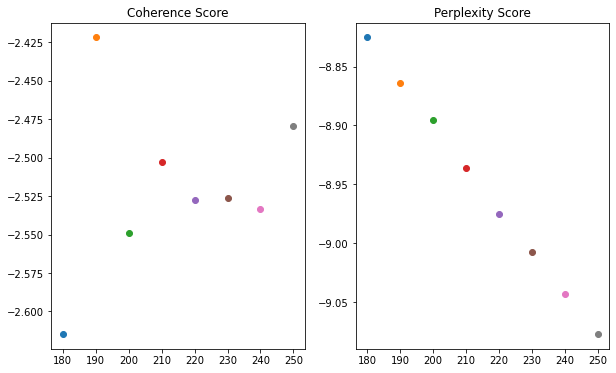

In [13]:
# for plotting 
k_range = np.linspace(0, 15) 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

max_k = 260

# create word list for coherence scoring
text = []
for i in range(0,len(DOJ)):
    words = re.findall('\w+', DOJ[i])
    text.append(words)

print("Done word list")
    
# train LDA models with 3 topics to max_k topics and plot their coherence score and perplexity score
l = max_k - 3
for k in range(180, max_k, 10):
    start = time.time()
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word = df_id,
                                                num_topics = k,
                                                random_state=52,
                                                update_every=100,
                                                chunksize=10000, 
                                                passes=2, alpha="auto", eta = "auto") 

    coherence_model_lda = CoherenceModel(model=lda_model, texts=text, dictionary=df_id, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    axes[0].scatter(k, coherence_lda)
    PerWordPP = lda_model.log_perplexity(corpus)
    axes[1].scatter(k, PerWordPP)
    print(round((k-3)/l, 4)*100, ' %')
    lda_model.save('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/models/'+str(k)+'_model_fast.model')
    end = time.time()
    print(end-start)
    
axes[0].set_title('Coherence Score')
axes[1].set_title('Perplexity Score')

In [43]:
# now build your final LDA model with your chosen number of topics
tops = 190

start = time.time()

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word = df_id,num_topics =tops,
                                            random_state=52,
                                            update_every=5,
                                            chunksize=500,
                                            passes=8,
                                            alpha="auto",
                                            eta = "auto") 


end = time.time()
print(end-start)

lda_model.save('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/models/190_model_slow_V5.model')


4910.51869392395


In [31]:
# print the most frequent words in each topic
from pprint import pprint
pprint(lda_model.print_topic(46))

('0.038*"business" + 0.029*"company" + 0.013*"work" + 0.012*"employee" + '
 '0.009*"need" + 0.009*"small" + 0.009*"firm" + 0.009*"like" + 0.009*"help" + '
 '0.009*"big"')


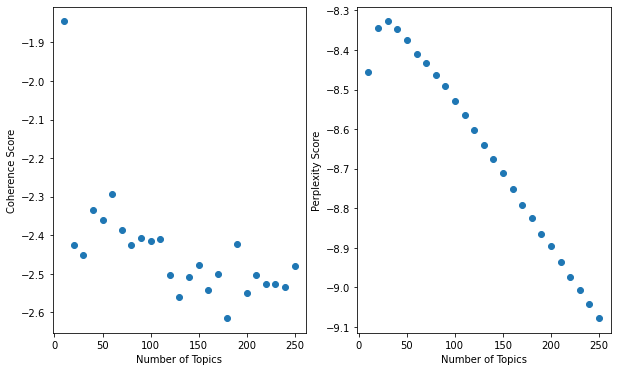

In [18]:
import matplotlib.pyplot as plt

coh_list = [-1.8457556307621452, -2.4256523138446364, -2.4519366265143026, -2.3343176132476295, -2.3615841871775896, \
            -2.292877322087626, -2.3859555585998047, -2.424683940430401, -2.4075946233672396, -2.4143309553268297, \
            -2.4105116579761576, -2.5036319267181733, -2.5605178188031634, -2.5080676299704354, -2.475975156294528, \
            -2.5418008242447803, -2.50119745024119, -2.6146235910746762, -2.4218266878096757, -2.54915043536991, \
            -2.5029642772046286, -2.527504324902838, -2.5264165650204493, -2.5331816066579873, -2.479175015617633]

perp_list = [-8.455719866566382, -8.344690535865945,-8.327926660125804,-8.347061633235592,-8.374199357317616, \
             -8.409815339705299, -8.434018338071974,-8.46237627976206,-8.491889154231332,-8.52809068553354, \
              -8.563372935991538,-8.60339824609793, -8.639607528567756,-8.675510516910887, -8.710992209497014, \
             -8.750423425113105, -8.792464331918268,-8.825309310807969,-8.863900508652007,-8.895526716558534, \
             -8.935616511094423, -8.974889135357678, -9.007757755482135,-9.042594225607395,-9.077401072501289]

#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

#axes[0].set_title('Coherence Score')
#axes[1].set_title('Perplexity Score')

x_ax = [i for i in range(10, 260, 10)]

#for i in range(10, 260, 10):
    #axes[0].plot(i, coh_list[i])
#    plt.plot(i, coh_list[i])
    #axes[1].plot(i, perp_list[i])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
ax[0].set_xlabel('Number of Topics')
ax[0].set_ylabel('Coherence Score')    

ax[0].scatter(x_ax, coh_list)
    
#plt.show()


ax[1].set_xlabel('Number of Topics')
ax[1].set_ylabel('Perplexity Score') 

ax[1].scatter(x_ax, perp_list)

fig.show()